# MODIS 
## ...on a map

This notebook takes a look at how to superimpose a MODIS image on a map


**Missing: How this data file is pulled into the local data directory...**

In [60]:
%matplotlib inline
import timeit
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import numpy as np
from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import sys
import os

In [61]:
# Some Python utility code
from pathlib import Path
home = str(Path.home()) + '/'
data = home + 'data/'             # A non-repository location for datasets of interest

def dirobj(obj): return [x for x in dir(obj) if not x.startswith('_')]

def lsal(path=''):
    import os
    return os.popen('ls -al ' + path).readlines()

def ShowGitHubImage(username, repo, folder, source, localcopyname, width, height):
    import requests, shutil
    from PIL import Image
    outf = home + localcopyname
    f = 'https://raw.githubusercontent.com/' + username + '/' + repo + '/master/' + folder + '/' + source
    a = requests.get(f, stream = True)
    if a.status_code == 200:
        with open(outf, 'wb') as f:
            a.raw.decode_content = True
            shutil.copyfileobj(a.raw, f)
    return Image.open(outf).resize((width,height),Image.ANTIALIAS)

def ShowLocalImage(pathfromhome, filename, width, height):
    import shutil
    from PIL import Image
    global home
    f = home + '/' + pathfromhome + '/' + filename 
    return Image.open(f).resize((width,height),Image.ANTIALIAS)

# Test either of the 'Show Image' functions
# ShowGitHubImage('robfatland', 'othermathclub', 'images/cellular', 'conus_textile_shell_2.png', 'ctextile.jpg', 450, 250)
# ShowLocalImage('.', 'ctextile.jpg', 450, 250)


In [62]:
# verify the MODIS example file is present
modis_d = data + 'modis/'
image_d = data + 'images/'
lsal(modis_d)

['total 256\n',
 'drwxrwsr-x  2 jovyan users   4096 Jul 28 21:48 .\n',
 'drwxrwsr-x 20 jovyan users   4096 Jan 13 21:44 ..\n',
 '-rw-rw-r--  1 jovyan users 252333 Jul 28 21:48 g4.subsetted.MODISA_L3m_SST_2014_sst.20160101.138W_40N_122W_54N.nc\n']

In [63]:
lsal(image_d)

['total 852\n',
 'drwxrwsr-x  3 jovyan users   4096 Dec 20 20:42 .\n',
 'drwxrwsr-x 20 jovyan users   4096 Jan 13 21:44 ..\n',
 '-rw-rw-r--  1 jovyan users 382893 Jul 25 06:21 ARGO_BB_selection.png\n',
 'drwxrwsr-x  2 jovyan users   4096 Jul 31 20:16 .ipynb_checkpoints\n',
 '-rw-rw-r--  1 jovyan users 169276 Jul 31 20:16 modis_sst.png\n',
 '-rw-rw-r--  1 jovyan users 300878 Aug  3 21:49 profilers_depth_24_hours.png\n']

In [64]:
# check: can open_msdataset work against multiple MODIS *.nc files?

# standard inputs plus assign the modis data to a dataset list as element 0 of m[]

if not os.path.exists(modis_d):
    print('sorry the modis directory does not seem to be present where I expected it (~/data/modis)')
    sys.exit(0)
    
fnm_field_index = 8                                          # index of the filename after the ls line is split
m=[]                                                         # a list of MODIS datasets
stipulate = '*MODIS*.nc'                                     # profiles; not trajectories for now
r = os.popen('ls -al ' + modis_d + stipulate).readlines()   # list of MODIS netCDF data files

for q in r:
    b=q.split()[fnm_field_index].rstrip()   # filename with no whitespace
    m.append(xr.open_mfdataset(b))          # ds now a working dataset list (with but one element)

print('Number of modis datasets: ', len(m))

Number of modis datasets:  1


<xarray.DataArray 'MODISA_L3m_SST_2014_sst' (time: 1, lat: 320, lon: 388)>
dask.array<shape=(1, 320, 388), dtype=float32, chunksize=(1, 320, 388)>
Coordinates:
  * lat      (lat) float32 40.8125 40.854168 40.895832 40.9375 40.979168 ...
  * lon      (lon) float32 -138.47917 -138.4375 -138.39583 -138.35417 ...
  * time     (time) datetime64[ns] 2016-01-01T00:15:10
Attributes:
    display_max:         45.0
    display_min:         -2.0
    display_scale:       linear
    long_name:           Sea Surface Temperature at 11 microns (Day)
    product_short_name:  MODISA_L3m_SST
    product_version:     2014
    quantity_type:       Energy
    standard_name:       sea_surface_temperature
    valid_max:           38.0
    valid_min:           -2.0
    units:               C
40.8125 -138.47917 54.104168 -122.354164


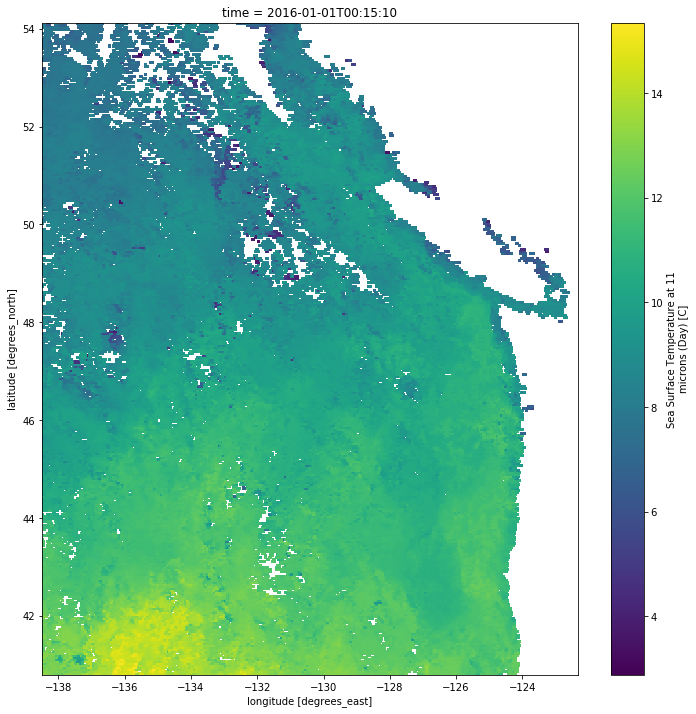

In [65]:
modis = m[0]
print(modis.MODISA_L3m_SST_2014_sst)
print(modis.lat.values[0], modis.lon.values[0], modis.lat.values[-1], modis.lon.values[-1])
modisplot = modis.MODISA_L3m_SST_2014_sst.plot(figsize=(12,12))

### intermezzo remarks

- The image saver below does not work properly; I just get an empty image...
- The nbextension command should *not* be necessary but it is for the record:
  
```
jupyter nbextension enable --py --sys-prefix ipyleaflet
```

- install the MODIS WMS from [here](https://lpdaac.usgs.gov/data_access/web_map_services_wms)

So basically lots to do here.

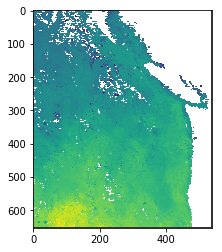

In [17]:
# bug: This does not work properly yet
# plt.savefig(data + '/images/modis_SST.png')
img=matplotlib.image.imread(data + 'images/modis_sst.png')
imgplot = plt.imshow(img)
# plt.show()

In [59]:
# The goal is to overlay an image (created earlier; .png file) with a controllable opacity
# 
# How I got to opacity control through a sequence of print statements: 
#   print(thisMap)
#   print(thisMap.layers)
#   print(thisMap.layers[1])                    which is cheating by hardcoding the layer index as 1
#   print(thisMap.layers[1].opacity)
#   therefore setting thisMap.layers[1].opacity = 0.2 works just fine

def ChangeMapOpacity(opacity):thisMap.layers[1].opacity = opacity

from ipyleaflet import Map, ImageOverlay, WMSLayer
opacity = 0.7
thisMap = Map(center=(47, -129), zoom=5, layout=Layout(width='100%', height='600px'))
# The path to the image for overlay is relative; I could not get an absolute path to work...
sourceImage =  '../data/images/modis_sst.png'
image_layer = ImageOverlay(url=sourceImage, bounds=((40.2, -138.58), (53.8, -122.45)), opacity=opacity)
thisMap.add_layer(image_layer)


interact(ChangeMapOpacity, opacity = widgets.FloatSlider(min=0., max=1., step=0.025, value=opacity, 
      continuous_update=False, display='Opacity'))

# It seems that 'thisMap' must be the last line of code in the cell, hence placing interact() above
thisMap

# The following works but does not track zoom with new higher resolution tiles
# wms = WMSLayer(url="https://demo.boundlessgeo.com/geoserver/ows?",layers="nasa:bluemarble")
# thisMap.add_layer(wms)
    

interactive(children=(FloatSlider(value=0.7, continuous_update=False, description='opacity', max=1.0, step=0.0…

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [48]:
# This cell selects out MODIS-derived sea surface temperature in deg C at specific locations
#   This is for comparative work with in situ sensors in the Regional Cabled Observatory, which is
#   in turn part of the NSF-sponsored Ocean Observing Initiative

eoLat, eoLon, eoDep          = 44. + 22./60. + 10./3600., -(124. + 57./60. + 15./3600.),  582.
osbLat, osbLon, osbDep       = 44. + 30./60. + 55./3600., -(125. + 23./60. + 23./3600.), 2906.
shrLat, shrLon, shrDep       = 44. + 34./60. +  9./3600., -(125  +  8./60. + 53./3600.),  778.
axbLat, axbLon, axbDep       = 45. + 49./60. +  5./3600., -(129. + 45./60. + 13./3600.), 2605.
ashesLat, ashesLon, ashesDep = 45. + 56./60. +  1./3600., -(130. +  0./60. + 50./3600.), 1543.
axcLat, axcLon, axcDep       = 45. + 57./60. + 17./3600., -(130. +  0./60. + 32./3600.), 1528.
axeLat, axeLon, axeDep       = 45. + 56./60. + 23./3600., -(129. + 58./60. + 27./3600.), 1516.
axiLat, axiLon, axiDep       = 45. + 53./60. + 35./3600., -(129. + 58./60. + 44./3600.), 1520.
ca = [('Endurance Offshore',                eoLat,    eoLon,    eoDep, 'Endurance Offshore'),
      ('Oregon Slope Base',                osbLat,   osbLon,   osbDep, 'Oregon Slope Base'),
      ('Southern Hydrate Ridge',           shrLat,   shrLon,   shrDep, 'Southern Hydrate Ridge'),
      ('Axial Base',                       axbLat,   axbLon,   axbDep, 'Axial Base'),
      ('Axial ASHES Vent Field',         ashesLat, ashesLon, ashesDep, 'Inferno vent'),
      ('Axial Caldera Center',             axcLat,   axcLon,   axcDep, 'Axial Caldera Center'),
      ('Axial Caldera East',               axeLat,   axeLon,   axeDep, 'Axial Caldera East'),
      ('Axial International Vent Field',   axiLat,   axiLon,   axiDep, 'Axial International Vent Field')
    ]

# for i in ca: print(i[0], i[1], i[2])
# for i in range(3): for j in range(3): print(m.MODISA_L3m_SST_2014_sst[0][i][j].values)
# 
# testLat = ca[1][1]       #   44.51528
# testLon = ca[1][2]       # -125.38972
# print(testLat, testLon)

sst = []
for i in range(len(ca)):
    # print(m.MODISA_L3m_SST_2014_sst.sel(lat=ca[i][1], lon=ca[i][2], method = 'nearest'))
    temp = modis.MODISA_L3m_SST_2014_sst.sel(lat=ca[i][1], lon=ca[i][2], method = 'nearest').values
    sst.append(round(float(temp[0]), 2))

# Here are MODIS-derived day-time sea surface temperatures at the cabled array locations on 2016-01-01T00:15:10 
print(sst)

[11.51, 11.27, 11.47, 10.66, 10.41, 10.41, 10.42, 10.48]


In [42]:
# And this works properly albeit with limited tiling resolution
from ipyleaflet import Map, WMSLayer
wms = WMSLayer(
url="https://demo.boundlessgeo.com/geoserver/ows?",
layers="nasa:bluemarble"
)
m = Map(layers=(wms, ), center=(42.5531, -48.6914), zoom=3)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …